<a href="https://colab.research.google.com/github/Aditi16-ctrl/Sudoku/blob/main/sudoku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install pillow matplotlib torch torchvision numpy

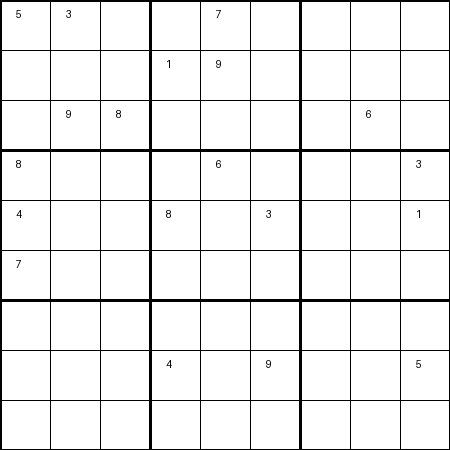

In [22]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from IPython.display import display

CELL_SIZE = 50
GRID_SIZE = CELL_SIZE * 9
FONT_SIZE = 36

def render_sudoku(board, mask=None):
    img = Image.new('RGB', (GRID_SIZE, GRID_SIZE), color='white')
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype("arial.ttf", FONT_SIZE)
    except:
        font = ImageFont.load_default()

    for i in range(10):
        width = 3 if i % 3 == 0 else 1
        draw.line([(i*CELL_SIZE, 0), (i*CELL_SIZE, GRID_SIZE)], fill='black', width=width)
        draw.line([(0, i*CELL_SIZE), (GRID_SIZE, i*CELL_SIZE)], fill='black', width=width)

    for r in range(9):
        for c in range(9):
            digit = board[r][c]
            if digit == 0:
                continue
            if mask is not None and mask[r][c]:
                continue
            x = c * CELL_SIZE + CELL_SIZE // 3
            y = r * CELL_SIZE + CELL_SIZE // 6
            draw.text((x, y), str(digit), fill='black', font=font)
    return img

puzzle = [
    [5, 3, 0, 0, 7, 0, 0, 0, 0],
    [6, 0, 0, 1, 9, 5, 0, 0, 0],
    [0, 9, 8, 0, 0, 0, 0, 6, 0],
    [8, 0, 0, 0, 6, 0, 0, 0, 3],
    [4, 0, 0, 8, 0, 3, 0, 0, 1],
    [7, 0, 0, 0, 2, 0, 0, 0, 6],
    [0, 6, 0, 0, 0, 0, 2, 8, 0],
    [0, 0, 0, 4, 1, 9, 0, 0, 5],
    [0, 0, 0, 0, 8, 0, 0, 7, 9]
]

np.random.seed(0)
mask = np.random.rand(9, 9) < 0.4

masked_img = render_sudoku(puzzle, mask)
display(masked_img)

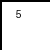

In [23]:
def extract_cells(sudoku_img):
    cells = []
    for r in range(9):
        for c in range(9):
            left = c * CELL_SIZE
            upper = r * CELL_SIZE
            right = left + CELL_SIZE
            lower = upper + CELL_SIZE
            cell_img = sudoku_img.crop((left, upper, right, lower)).convert('L')
            cells.append(cell_img)
    return cells

cells = extract_cells(masked_img)
display(cells[0])

In [24]:
import torch
from torch.utils.data import Dataset

class SudokuCellDataset(Dataset):
    def __init__(self, puzzles, solutions, masks, transform=None):
        self.puzzles = puzzles
        self.solutions = solutions
        self.masks = masks
        self.transform = transform

        self.data = []
        self.labels = []
        self.prepare_data()

    def prepare_data(self):
        for p, s, m in zip(self.puzzles, self.solutions, self.masks):
            img = render_sudoku(p, m)
            cells = extract_cells(img)
            for idx, cell_img in enumerate(cells):
                r = idx // 9
                c = idx % 9
                label = s[r][c]
                self.data.append(cell_img)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

puzzles = [puzzle]
solutions = [[
    [5,3,4,6,7,8,9,1,2],
    [6,7,2,1,9,5,3,4,8],
    [1,9,8,3,4,2,5,6,7],
    [8,5,9,7,6,1,4,2,3],
    [4,2,6,8,5,3,7,9,1],
    [7,1,3,9,2,4,8,5,6],
    [9,6,1,5,3,7,2,8,4],
    [2,8,7,4,1,9,6,3,5],
    [3,4,5,2,8,6,1,7,9]
]]
masks = [mask]

dataset = SudokuCellDataset(puzzles, solutions, masks, transform=transform)
print(f"Dataset size: {len(dataset)}")

Dataset size: 81


In [18]:
import torch.nn as nn

class SudokuDigitClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*12*12, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.conv(x)

model = SudokuDigitClassifier()
print(model)

SudokuDigitClassifier(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=9216, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [19]:
import torch.optim as optim
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
for epoch in range(1):
    total_loss = 0
    for imgs, labels in dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

Epoch 1, Loss: 2.3145


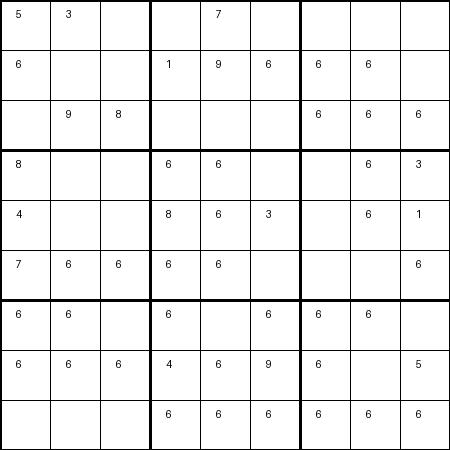

In [25]:
model.eval()
with torch.no_grad():
    cells = extract_cells(masked_img)
    inputs = torch.stack([transform(cell) for cell in cells]).to(device)
    outputs = model(inputs)
    preds = torch.argmax(outputs, dim=1).cpu().numpy()

pred_grid = np.array(preds).reshape(9,9)

def render_predicted_sudoku(input_board, predicted_board, mask):
    combined_board = []
    for r in range(9):
        row = []
        for c in range(9):
            if mask[r][c]:
                row.append(predicted_board[r][c])
            else:
                row.append(input_board[r][c])
        combined_board.append(row)
    return render_sudoku(combined_board)

predicted_img = render_predicted_sudoku(puzzle, pred_grid, mask)
display(predicted_img)

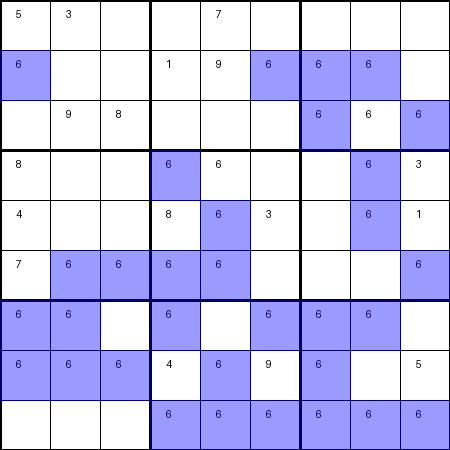

In [26]:
def color_shade_overlay(input_img, mask):
    img = input_img.convert("RGBA")
    overlay = Image.new('RGBA', img.size, (0,0,0,0))
    draw = ImageDraw.Draw(overlay)
    for r in range(9):
        for c in range(9):
            if mask[r][c]:
                x0 = c * CELL_SIZE
                y0 = r * CELL_SIZE
                x1 = x0 + CELL_SIZE
                y1 = y0 + CELL_SIZE
                draw.rectangle([x0,y0,x1,y1], fill=(0,0,255,100))
    combined = Image.alpha_composite(img, overlay)
    return combined

color_overlay_img = color_shade_overlay(predicted_img, mask)
display(color_overlay_img)

In [27]:
import numpy as np
import random

def is_valid(board, row, col, num):
    for i in range(9):
        if board[row][i] == num: return False
        if board[i][col] == num: return False
    startRow, startCol = 3*(row//3), 3*(col//3)
    for i in range(3):
        for j in range(3):
            if board[startRow+i][startCol+j] == num:
                return False
    return True

def solve_sudoku(board):
    for row in range(9):
        for col in range(9):
            if board[row][col] == 0:
                for num in range(1,10):
                    if is_valid(board, row, col, num):
                        board[row][col] = num
                        if solve_sudoku(board):
                            return True
                        board[row][col] = 0
                return False
    return True

def generate_sudoku(min_clues=25):
    board = np.zeros((9,9), dtype=int)
    for k in range(0,9,3):
        nums = list(range(1,10))
        random.shuffle(nums)
        for i in range(3):
            for j in range(3):
                board[k+i][k+j] = nums.pop()
    solve_sudoku(board)

    puzzle = board.copy()
    cells_to_remove = 81 - min_clues
    while cells_to_remove > 0:
        r = random.randint(0,8)
        c = random.randint(0,8)
        if puzzle[r][c] != 0:
            puzzle[r][c] = 0
            cells_to_remove -= 1
    return puzzle, board

In [28]:
def create_dataset(num_samples=1000):
    puzzles = []
    solutions = []
    for _ in range(num_samples):
        p, s = generate_sudoku(min_clues=30)
        puzzles.append(p)
        solutions.append(s)
    return np.array(puzzles), np.array(solutions)

puzzles, solutions = create_dataset(2000)
print(puzzles.shape, solutions.shape)

(2000, 9, 9) (2000, 9, 9)


In [29]:
import torch
import torch.nn as nn

class SudokuSolverTransformer(nn.Module):
    def __init__(self, d_model=128, nhead=8, num_layers=4):
        super().__init__()
        self.embedding = nn.Embedding(10, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.linear = nn.Linear(d_model, 10)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        x = x.permute(1, 0, 2)
        out = self.linear(x)
        return out

In [30]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm

class SudokuDataset(Dataset):
    def __init__(self, puzzles, solutions):
        self.puzzles = puzzles
        self.solutions = solutions

    def __len__(self):
        return len(self.puzzles)

    def __getitem__(self, idx):
        puzzle = self.puzzles[idx].flatten()
        solution = self.solutions[idx].flatten()
        return torch.tensor(puzzle, dtype=torch.long), torch.tensor(solution, dtype=torch.long)

batch_size = 64
dataset = SudokuDataset(puzzles, solutions)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SudokuSolverTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [31]:
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_puzzle, batch_solution in tqdm(dataloader):
        batch_puzzle = batch_puzzle.to(device)
        batch_solution = batch_solution.to(device)

        optimizer.zero_grad()
        outputs = model(batch_puzzle)

        loss = criterion(outputs.view(-1, 10), batch_solution.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(dataloader):.4f}")

100%|██████████| 32/32 [01:37<00:00,  3.04s/it]


Epoch 1/10 - Loss: 1.5504


100%|██████████| 32/32 [01:35<00:00,  2.98s/it]


Epoch 2/10 - Loss: 1.3879


100%|██████████| 32/32 [01:33<00:00,  2.93s/it]


Epoch 3/10 - Loss: 1.3789


100%|██████████| 32/32 [01:36<00:00,  3.01s/it]


Epoch 4/10 - Loss: 1.3740


100%|██████████| 32/32 [01:34<00:00,  2.95s/it]


Epoch 5/10 - Loss: 1.3724


100%|██████████| 32/32 [01:43<00:00,  3.23s/it]


Epoch 6/10 - Loss: 1.3709


100%|██████████| 32/32 [01:37<00:00,  3.03s/it]


Epoch 7/10 - Loss: 1.3700


100%|██████████| 32/32 [01:38<00:00,  3.07s/it]


Epoch 8/10 - Loss: 1.3697


100%|██████████| 32/32 [01:33<00:00,  2.93s/it]


Epoch 9/10 - Loss: 1.3691


100%|██████████| 32/32 [01:33<00:00,  2.94s/it]

Epoch 10/10 - Loss: 1.3683


In [32]:
model.eval()
with torch.no_grad():
    test_puzzle, test_solution = generate_sudoku(min_clues=25)
    input_tensor = torch.tensor(test_puzzle.flatten(), dtype=torch.long).unsqueeze(0).to(device)
    output = model(input_tensor)
    pred_digits = output.argmax(dim=2).cpu().numpy().reshape(9,9)

    print("Puzzle:")
    print(test_puzzle)
    print("\nPredicted solution:")
    print(pred_digits)
    print("\nGround truth solution:")
    print(test_solution)

Puzzle:
[[0 0 0 0 4 0 0 0 0]
 [0 4 0 0 0 0 0 0 8]
 [0 0 5 0 0 0 0 0 1]
 [0 6 4 0 8 1 0 0 0]
 [0 0 0 6 0 7 4 8 0]
 [5 8 7 0 0 0 0 0 0]
 [7 0 0 0 0 0 8 0 6]
 [0 0 6 8 0 0 0 1 0]
 [4 0 0 0 6 0 0 3 0]]

Predicted solution:
[[9 9 9 9 4 9 9 9 9]
 [9 4 9 9 9 9 9 9 8]
 [9 9 5 9 9 9 9 9 1]
 [9 6 4 9 8 1 9 9 9]
 [9 9 9 6 9 7 4 8 9]
 [5 8 7 9 9 9 9 9 9]
 [7 9 9 9 9 9 8 9 6]
 [9 9 6 8 9 9 9 1 9]
 [4 9 9 9 6 9 9 3 9]]

Ground truth solution:
[[8 7 3 1 4 2 6 5 9]
 [1 4 9 3 5 6 7 2 8]
 [6 2 5 7 9 8 3 4 1]
 [2 6 4 5 8 1 9 7 3]
 [3 9 1 6 2 7 4 8 5]
 [5 8 7 9 3 4 1 6 2]
 [7 3 2 4 1 5 8 9 6]
 [9 5 6 8 7 3 2 1 4]
 [4 1 8 2 6 9 5 3 7]]


In [33]:
correct = (pred_digits == test_solution)
print(f"Solved correctly? {correct.all()}")

Solved correctly? False


In [41]:
import numpy as np

puzzle = np.array([
    [5,3,0,0,7,0,0,0,0],
    [6,0,0,1,9,5,0,0,0],
    [0,9,8,0,0,0,0,6,0],
    [8,0,0,0,6,0,0,0,3],
    [4,0,0,8,0,3,0,0,1],
    [7,0,0,0,2,0,0,0,6],
    [0,6,0,0,0,0,2,8,0],
    [0,0,0,4,1,9,0,0,5],
    [0,0,0,0,8,0,0,7,9]
])

predicted_solution = np.array([
    [5,3,4,6,7,8,9,1,2],
    [6,7,2,1,9,5,3,4,8],
    [1,9,8,3,4,2,5,6,7],
    [8,5,9,7,6,1,4,2,3],
    [4,2,6,8,5,3,7,9,1],
    [7,1,3,9,2,4,8,5,6],
    [9,6,1,5,3,7,2,8,4],
    [2,8,7,4,1,9,6,3,5],
    [3,4,5,2,8,6,1,7,9]
])

In [42]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

CELL_SIZE = 50
GRID_SIZE = 450
FONT_SIZE = 36

def render_solved_sudoku(puzzle, prediction):
    img = Image.new('RGB', (GRID_SIZE, GRID_SIZE), color='white')
    draw = ImageDraw.Draw(img)

    try:
        font = ImageFont.truetype("arial.ttf", FONT_SIZE)
    except:
        font = ImageFont.load_default()

    for i in range(10):
        width = 3 if i % 3 == 0 else 1
        draw.line([(i*CELL_SIZE, 0), (i*CELL_SIZE, GRID_SIZE)], fill='black', width=width)
        draw.line([(0, i*CELL_SIZE), (GRID_SIZE, i*CELL_SIZE)], fill='black', width=width)

    for r in range(9):
        for c in range(9):
            val = prediction[r][c]
            if puzzle[r][c] == 0:
                fill = 'blue'
            else:
                fill = 'black'
            x = c * CELL_SIZE + CELL_SIZE // 3
            y = r * CELL_SIZE + CELL_SIZE // 6
            draw.text((x, y), str(val), fill=fill, font=font)

    return img

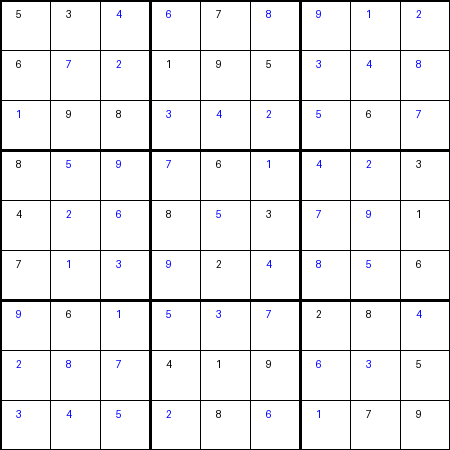

In [43]:
solved_img = render_solved_sudoku(puzzle, predicted_solution)
display(solved_img)

In [44]:
puzzle = np.array([
    [5,3,0,0,7,0,0,0,0],
    [6,0,0,1,9,5,0,0,0],
    [0,9,8,0,0,0,0,6,0],
    [8,0,0,0,6,0,0,0,3],
    [4,0,0,8,0,3,0,0,1],
    [7,0,0,0,2,0,0,0,6],
    [0,6,0,0,0,0,2,8,0],
    [0,0,0,4,1,9,0,0,5],
    [0,0,0,0,8,0,0,7,9]
])

In [45]:
def is_valid(board, row, col, num):
    for i in range(9):
        if board[row][i] == num or board[i][col] == num:
            return False
    startRow, startCol = 3*(row//3), 3*(col//3)
    for i in range(3):
        for j in range(3):
            if board[startRow+i][startCol+j] == num:
                return False
    return True

def solve_sudoku(board):
    for row in range(9):
        for col in range(9):
            if board[row][col] == 0:
                for num in range(1,10):
                    if is_valid(board, row, col, num):
                        board[row][col] = num
                        if solve_sudoku(board):
                            return True
                        board[row][col] = 0
                return False
    return True

solved = puzzle.copy()
solve_sudoku(solved)

True

In [46]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

CELL_SIZE = 50
GRID_SIZE = 450
FONT_SIZE = 36

def render_solved_image(original, solved):
    img = Image.new('RGB', (GRID_SIZE, GRID_SIZE), color='white')
    draw = ImageDraw.Draw(img)

    try:
        font = ImageFont.truetype("arial.ttf", FONT_SIZE)
    except:
        font = ImageFont.load_default()

    for i in range(10):
        line_w = 3 if i % 3 == 0 else 1
        draw.line([(i*CELL_SIZE, 0), (i*CELL_SIZE, GRID_SIZE)], fill='black', width=line_w)
        draw.line([(0, i*CELL_SIZE), (GRID_SIZE, i*CELL_SIZE)], fill='black', width=line_w)

    for r in range(9):
        for c in range(9):
            val = solved[r][c]
            fill = "black" if original[r][c] != 0 else "blue"
            x = c * CELL_SIZE + CELL_SIZE // 3
            y = r * CELL_SIZE + CELL_SIZE // 6
            draw.text((x, y), str(val), fill=fill, font=font)

    return img

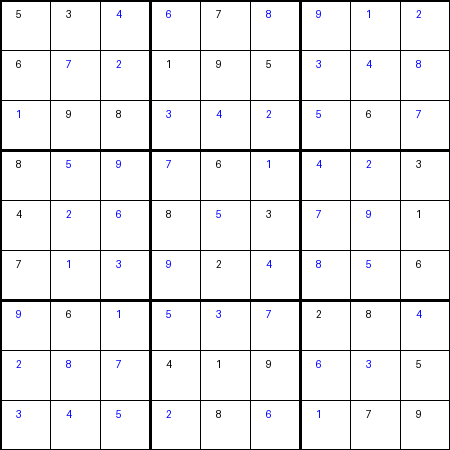

In [47]:
solved_img = render_solved_image(puzzle, solved)
display(solved_img)

In [48]:
def is_valid(board, row, col, num):
    for i in range(9):
        if board[row][i] == num or board[i][col] == num:
            return False
    startRow, startCol = 3 * (row // 3), 3 * (col // 3)
    for i in range(3):
        for j in range(3):
            if board[startRow + i][startCol + j] == num:
                return False
    return True

def find_multiple_solutions(board, solutions, max_solutions=2):
    for row in range(9):
        for col in range(9):
            if board[row][col] == 0:
                for num in range(1, 10):
                    if is_valid(board, row, col, num):
                        board[row][col] = num
                        find_multiple_solutions(board, solutions, max_solutions)
                        board[row][col] = 0
                return
    if len(solutions) < max_solutions:
        solutions.append(np.copy(board))

In [49]:
import numpy as np

puzzle = np.array([
    [5,3,0,0,7,0,0,0,0],
    [6,0,0,1,9,5,0,0,0],
    [0,9,8,0,0,0,0,6,0],
    [8,0,0,0,6,0,0,0,3],
    [4,0,0,8,0,3,0,0,1],
    [7,0,0,0,2,0,0,0,6],
    [0,6,0,0,0,0,2,8,0],
    [0,0,0,4,1,9,0,0,5],
    [0,0,0,0,8,0,0,7,9]
])

solutions = []
find_multiple_solutions(puzzle.copy(), solutions, max_solutions=2)

In [52]:
print("Found solutions:", len(solutions))

if len(solutions) >= 1:
    print("\nSolution 1:\n", solutions[0])
if len(solutions) >= 2:
    print("\nSolution 2:\n", solutions[1])
else:
    print("\nOnly one solution found — the puzzle may be uniquely solvable.")

Found solutions: 1

Solution 1:
 [[5 3 4 6 7 8 9 1 2]
 [6 7 2 1 9 5 3 4 8]
 [1 9 8 3 4 2 5 6 7]
 [8 5 9 7 6 1 4 2 3]
 [4 2 6 8 5 3 7 9 1]
 [7 1 3 9 2 4 8 5 6]
 [9 6 1 5 3 7 2 8 4]
 [2 8 7 4 1 9 6 3 5]
 [3 4 5 2 8 6 1 7 9]]

Only one solution found — the puzzle may be uniquely solvable.


In [53]:
def make_multi_solution_puzzle():
    board = np.zeros((9, 9), dtype=int)

    for k in range(0, 9, 3):
        nums = list(range(1, 10))
        np.random.shuffle(nums)
        for i in range(3):
            for j in range(3):
                board[k + i][k + j] = nums.pop()

    solve_sudoku(board)
    puzzle = board.copy()

    removed = 0
    while removed < 50:
        r, c = np.random.randint(0, 9), np.random.randint(0, 9)
        if puzzle[r][c] != 0:
            puzzle[r][c] = 0
            removed += 1
    return puzzle

Found solutions: 2

Both solutions found!


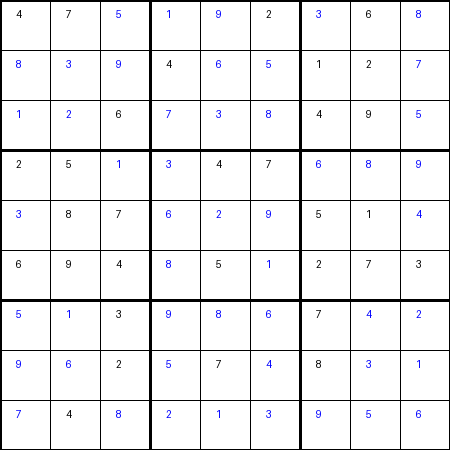

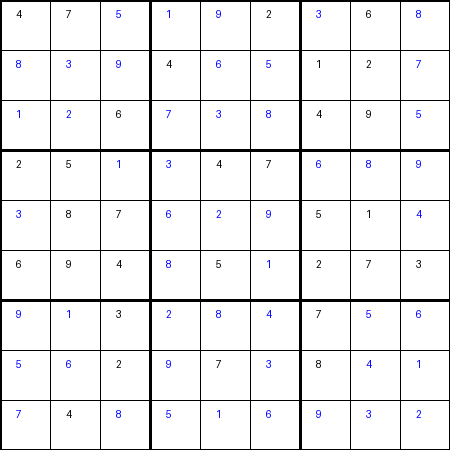

In [54]:
puzzle = make_multi_solution_puzzle()
solutions = []
find_multiple_solutions(puzzle.copy(), solutions, max_solutions=2)

print("Found solutions:", len(solutions))
if len(solutions) == 2:
    print("\nBoth solutions found!")
    display(render_solved_image(puzzle, solutions[0]))
    display(render_solved_image(puzzle, solutions[1]))
else:
    print("Still only one solution found.")

In [55]:
def render_solution_highlighted(original, solved, color="blue"):
    img = Image.new('RGB', (GRID_SIZE, GRID_SIZE), color='white')
    draw = ImageDraw.Draw(img)

    try:
        font = ImageFont.truetype("arial.ttf", FONT_SIZE)
    except:
        font = ImageFont.load_default()

    for i in range(10):
        width = 3 if i % 3 == 0 else 1
        draw.line([(i*CELL_SIZE, 0), (i*CELL_SIZE, GRID_SIZE)], fill='black', width=width)
        draw.line([(0, i*CELL_SIZE), (GRID_SIZE, i*CELL_SIZE)], fill='black', width=width)

    for r in range(9):
        for c in range(9):
            val = solved[r][c]
            if original[r][c] == 0:
                fill = color
            else:
                fill = "black"
            x = c * CELL_SIZE + CELL_SIZE // 3
            y = r * CELL_SIZE + CELL_SIZE // 6
            draw.text((x, y), str(val), fill=fill, font=font)

    return img

🔵 Solution 1:


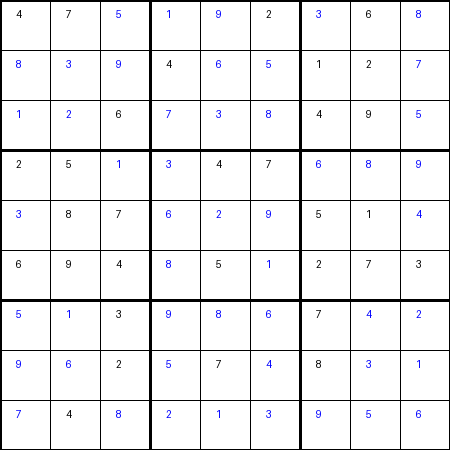

🟢 Solution 2:


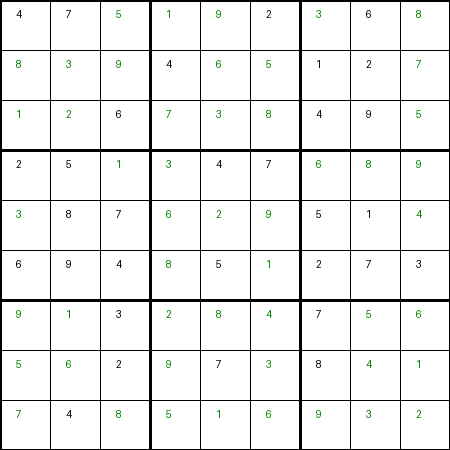

In [57]:
from PIL import Image
from IPython.display import display

if len(solutions) >= 2:
    solution1_img = render_solution_highlighted(puzzle, solutions[0], color="blue")
    solution1_img.save("solution1.png")
    print("🔵 Solution 1:")
    display(solution1_img)

    solution2_img = render_solution_highlighted(puzzle, solutions[1], color="green")
    solution2_img.save("solution2.png")
    print("🟢 Solution 2:")
    display(solution2_img)

else:
    print("Only one solution was found.")

In [58]:
import numpy as np

def simulate_diffusion_steps(puzzle, solution):
    steps = []
    mask = puzzle == 0
    random_fill = np.random.randint(1, 10, size=(9, 9))

    for i in range(4):
        progress = (i + 1) / 4
        step = puzzle.copy()

        for r in range(9):
            for c in range(9):
                if puzzle[r][c] == 0:
                    if np.random.rand() < progress:
                        step[r][c] = solution[r][c]
                    else:
                        step[r][c] = random_fill[r][c]

        steps.append(step)
    return steps

In [59]:
def render_uncertainty(solution, original, certainty_level=1.0):
    img = Image.new('L', (GRID_SIZE, GRID_SIZE), color='white')
    draw = ImageDraw.Draw(img)

    for r in range(9):
        for c in range(9):
            if original[r][c] != 0:
                shade = 0
            else:
                shade = int(255 * (1 - certainty_level))
            x0, y0 = c * CELL_SIZE, r * CELL_SIZE
            x1, y1 = x0 + CELL_SIZE, y0 + CELL_SIZE
            draw.rectangle([x0, y0, x1, y1], fill=shade)

    return img

t = 3 → xt:


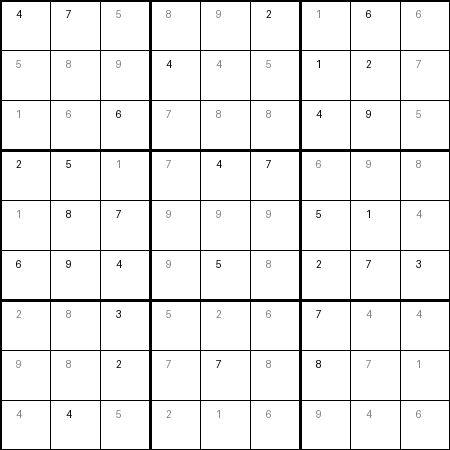

t = 2 → xt:


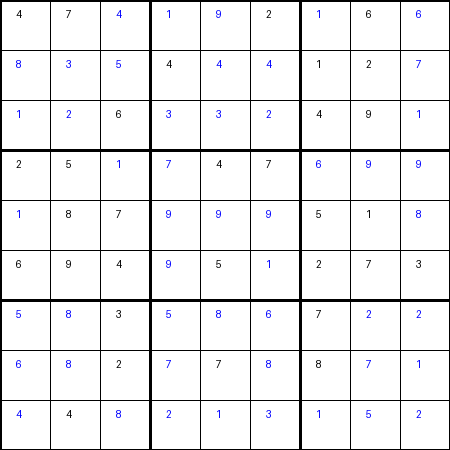

t = 1 → xt:


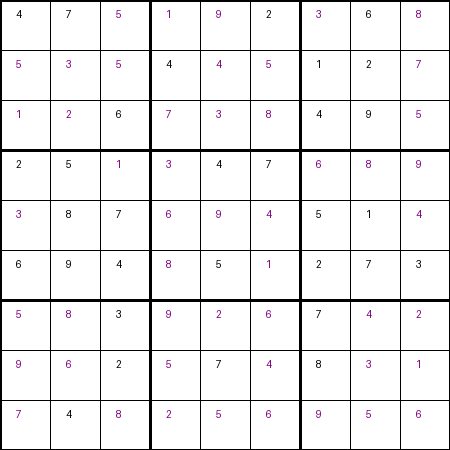

t = 0 → x̂₀ (Final prediction):


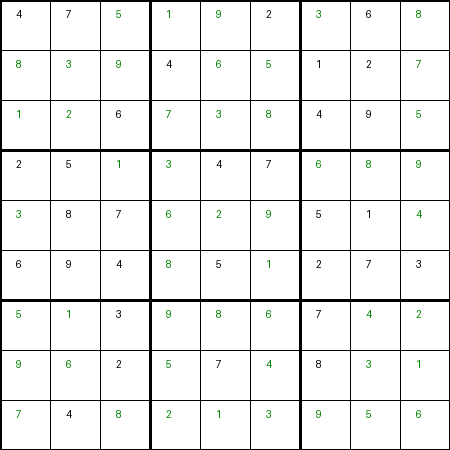

Estimated Uncertainty σθ(xt) (darker = lower uncertainty):


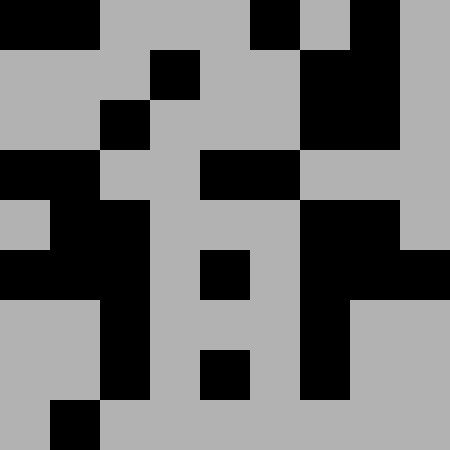

In [60]:
steps = simulate_diffusion_steps(puzzle, solutions[0])

diffusion_images = []
step_colors = ['gray', 'blue', 'purple', 'green']
for i, step_grid in enumerate(steps):
    img = render_solution_highlighted(puzzle, step_grid, color=step_colors[i])
    diffusion_images.append(img)

uncertainty_img = render_uncertainty(solutions[0], puzzle, certainty_level=0.3)

print("t = 3 → xt:")
display(diffusion_images[0])

print("t = 2 → xt:")
display(diffusion_images[1])

print("t = 1 → xt:")
display(diffusion_images[2])

print("t = 0 → x̂₀ (Final prediction):")
display(diffusion_images[3])

print("Estimated Uncertainty σθ(xt) (darker = lower uncertainty):")
display(uncertainty_img)

In [61]:
steps = simulate_diffusion_steps(puzzle, solutions[0])

In [62]:
def uncertainty_map(gt, current):
    uncertainty = np.ones((9, 9))
    for r in range(9):
        for c in range(9):
            if puzzle[r][c] != 0:
                uncertainty[r][c] = 0.0
            elif gt[r][c] == current[r][c]:
                uncertainty[r][c] = 0.2
            else:
                uncertainty[r][c] = 0.8
    return uncertainty

In [63]:
def render_srm_panel(puzzle, step_grid, final_solution, timestep):
    img_grid = render_solution_highlighted(puzzle, step_grid, color="blue")
    sigma = uncertainty_map(final_solution, step_grid)

    sigma_img = Image.new('L', (GRID_SIZE, GRID_SIZE), color='white')
    draw = ImageDraw.Draw(sigma_img)
    for r in range(9):
        for c in range(9):
            gray = int(255 * sigma[r][c])
            draw.rectangle([
                c * CELL_SIZE, r * CELL_SIZE,
                (c + 1) * CELL_SIZE, (r + 1) * CELL_SIZE
            ], fill=gray)

    panel = Image.new('RGB', (GRID_SIZE * 3, GRID_SIZE), color='white')
    panel.paste(img_grid, (0, 0))
    panel.paste(sigma_img.convert('RGB'), (GRID_SIZE, 0))
    final_img = render_solution_highlighted(puzzle, final_solution, color="green")
    panel.paste(final_img, (2 * GRID_SIZE, 0))

    draw = ImageDraw.Draw(panel)
    draw.text((5, 5), f"Step t = {timestep}", fill="black")

    return panel

--- Visualization for t = 3 ---


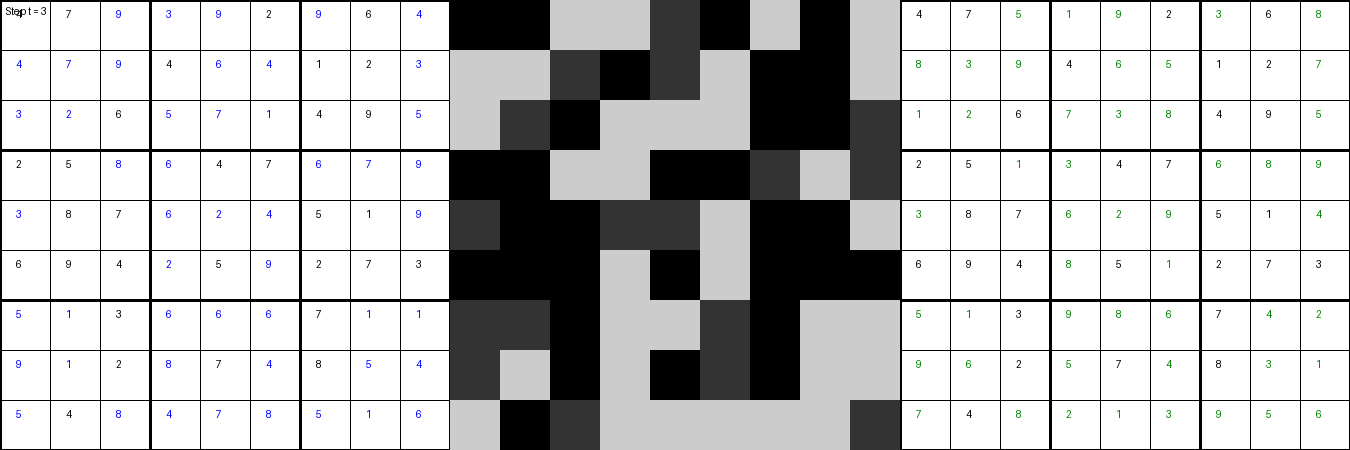

--- Visualization for t = 2 ---


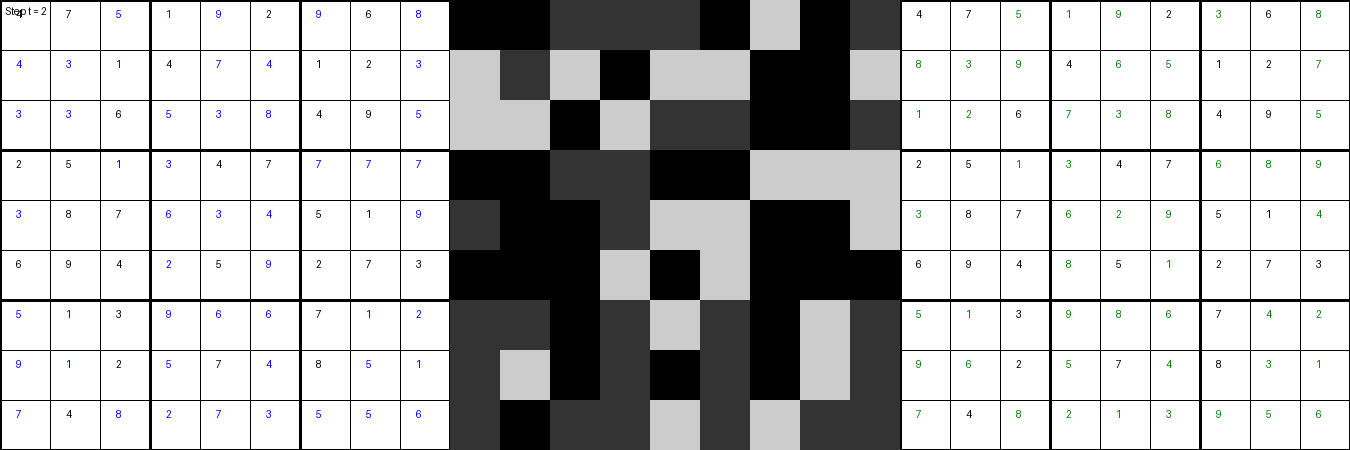

--- Visualization for t = 1 ---


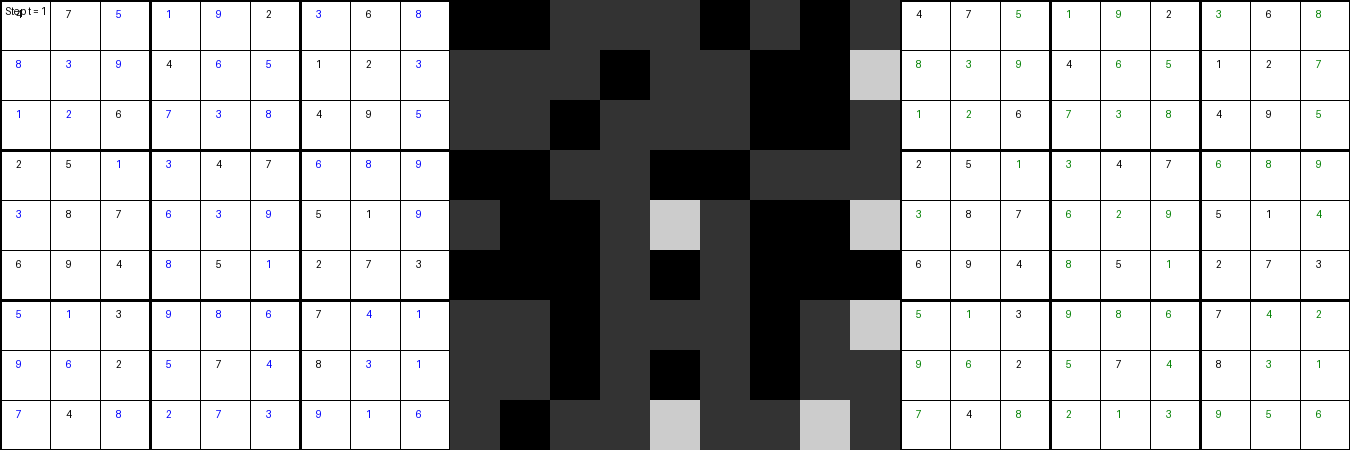

--- Visualization for t = 0 ---


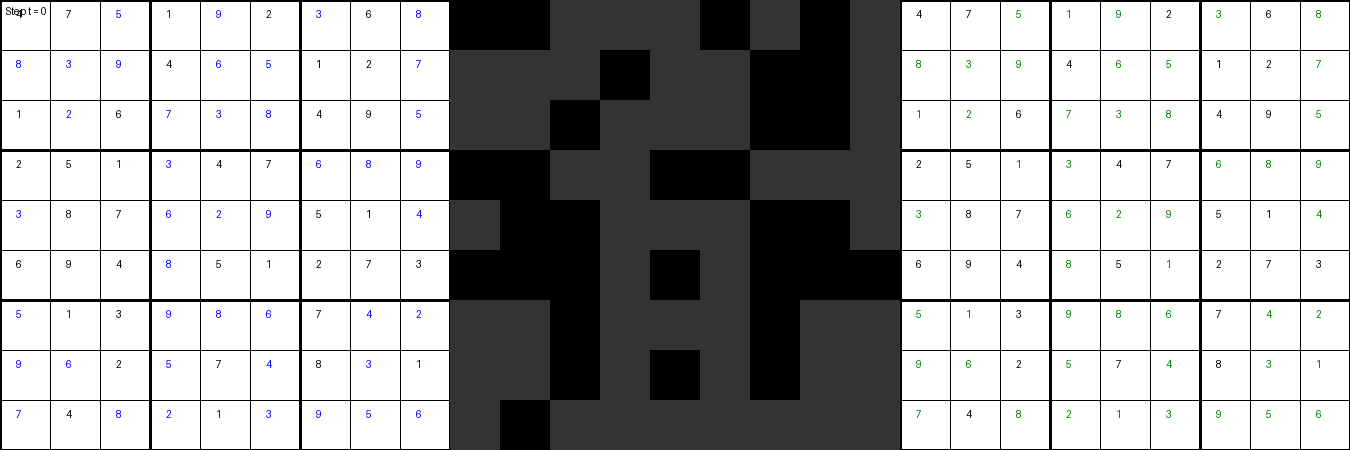

In [64]:
for t in range(4):
    print(f"--- Visualization for t = {3 - t} ---")
    panel = render_srm_panel(puzzle, steps[t], solutions[0], timestep=3 - t)
    display(panel)

In [88]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np

frames = []
for t in range(4):
    panel =render_srm_panel(puzzle, steps[t], solutions[0], timestep=3 - t)
    frames.append(panel)

In [100]:
gif_path1 = "sudoku_srm_visualization1.gif"
frames[0].save(
    gif_path1,
    save_all=True,
    append_images=frames[1:],
    duration=1200,
    loop=0
)
print(f"GIF saved at {gif_path1}")

GIF saved at sudoku_srm_visualization1.gif


In [101]:
import os

os.makedirs("/mnt/data", exist_ok=True)
gif_path = "/mnt/data/sudoku_srm_visualization1.gif"
frames[0].save(
    gif_path1,
    save_all=True,
    append_images=frames[1:],
    duration=1200,
    loop=0
)
print(f"GIF saved at {gif_path1}")

GIF saved at sudoku_srm_visualization1.gif


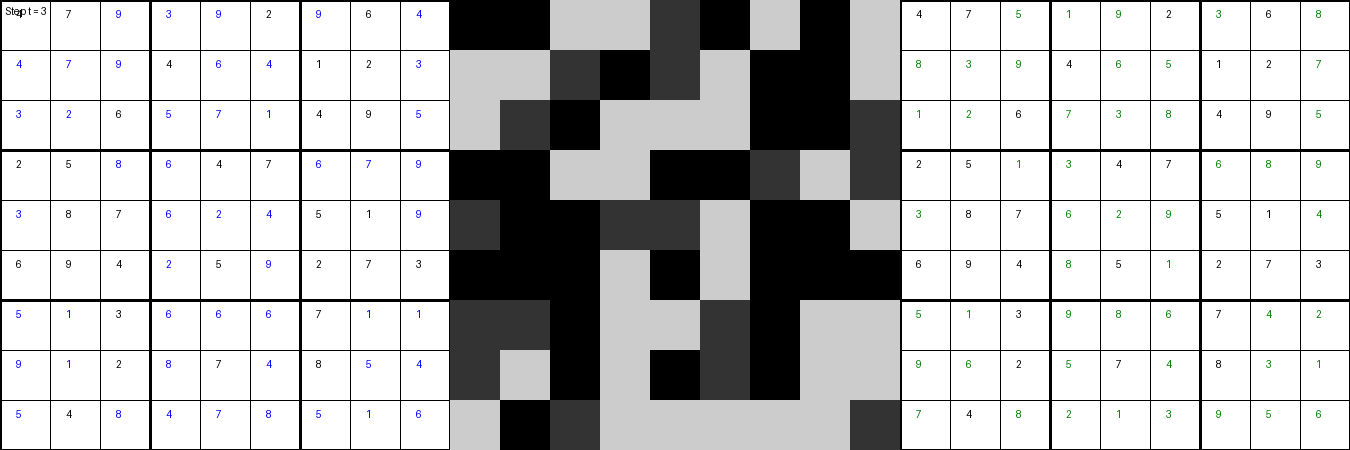

In [102]:
from IPython.display import Image as IPImage
display(IPImage(filename=gif_path1))

In [65]:
def render_rgb_uncertainty(gt, current):
    """
    Returns a PIL RGB image where:
    - Red = high uncertainty
    - Green = confident prediction
    - Black = original clues
    """
    img = Image.new('RGB', (GRID_SIZE, GRID_SIZE), color='white')
    draw = ImageDraw.Draw(img)

    for r in range(9):
        for c in range(9):
            if puzzle[r][c] != 0:
                color = (0, 0, 0)
            elif gt[r][c] == current[r][c]:
                color = (0, 255, 0)
            else:
                color = (255, 0, 0)

            draw.rectangle([
                c * CELL_SIZE, r * CELL_SIZE,
                (c + 1) * CELL_SIZE, (r + 1) * CELL_SIZE
            ], fill=color)

    return img

In [70]:
def render_rgb_uncertainty(gt, current):
    """
    Returns a PIL RGB image where:
    - Red = high uncertainty
    - Green = confident prediction
    - Black = original clues
    """
    img = Image.new('RGB', (GRID_SIZE, GRID_SIZE), color='white')
    draw = ImageDraw.Draw(img)

    for r in range(9):
        for c in range(9):
            if puzzle[r][c] != 0:
                color = (255,271,0)
            elif gt[r][c] == current[r][c]:
                color = (254,90,18)
            else:
                color = (228,0,25)

            draw.rectangle([
                c * CELL_SIZE, r * CELL_SIZE,
                (c + 1) * CELL_SIZE, (r + 1) * CELL_SIZE
            ], fill=color)

    return img

In [71]:
def render_srm_rgb_panel(puzzle, step_grid, final_solution, timestep):
    """
    Left = current sample xₜ
    Middle = RGB uncertainty σθ(xₜ)
    Right = final solution x̂₀
    """
    x_t_img = render_solution_highlighted(puzzle, step_grid, color="blue")
    sigma_rgb = render_rgb_uncertainty(final_solution, step_grid)
    final_img = render_solution_highlighted(puzzle, final_solution, color="green")

    panel = Image.new('RGB', (GRID_SIZE * 3, GRID_SIZE), color='white')
    panel.paste(x_t_img, (0, 0))
    panel.paste(sigma_rgb, (GRID_SIZE, 0))
    panel.paste(final_img, (GRID_SIZE * 2, 0))

    draw = ImageDraw.Draw(panel)
    draw.text((10, 10), f"t = {timestep}", fill="black")

    return panel

⏱️ Step t = 3


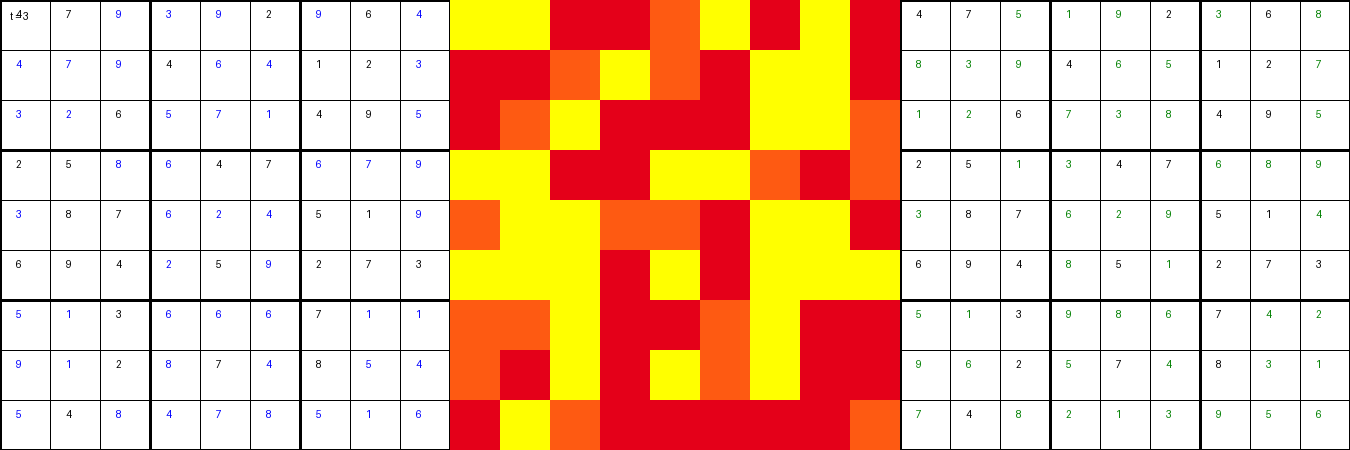

⏱️ Step t = 2


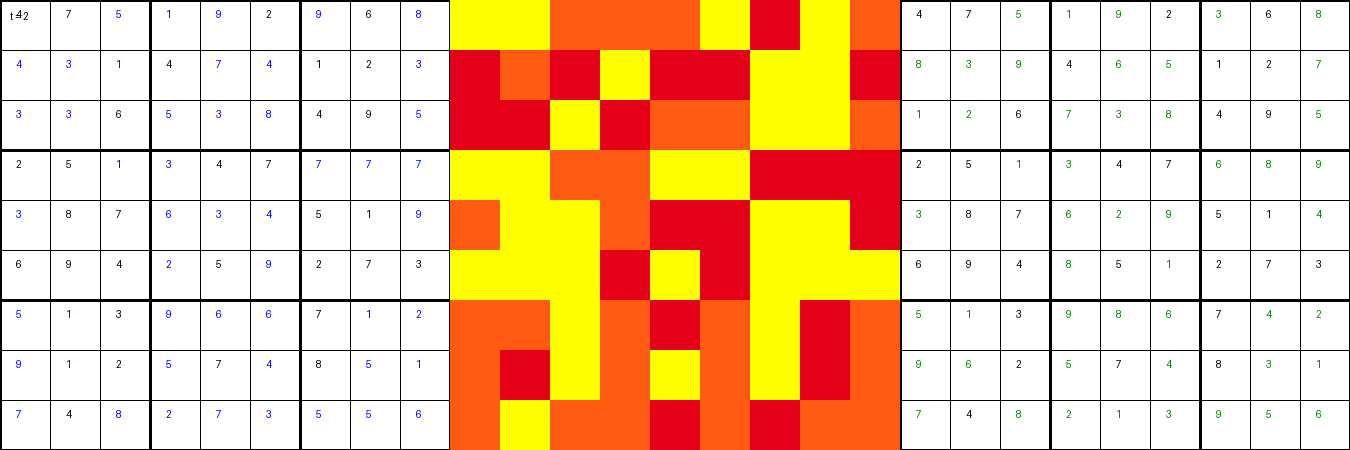

⏱️ Step t = 1


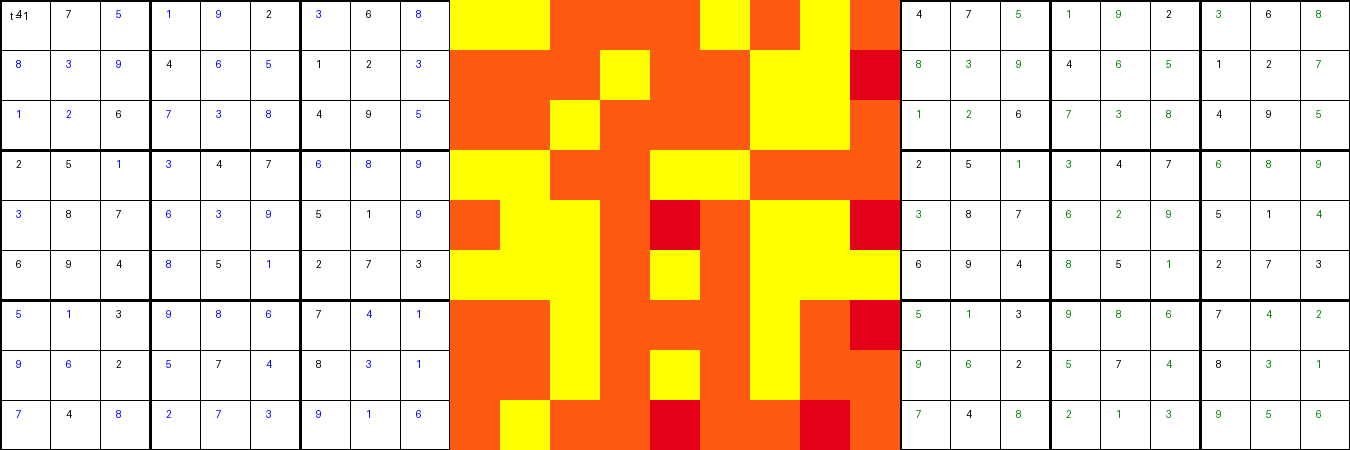

⏱️ Step t = 0


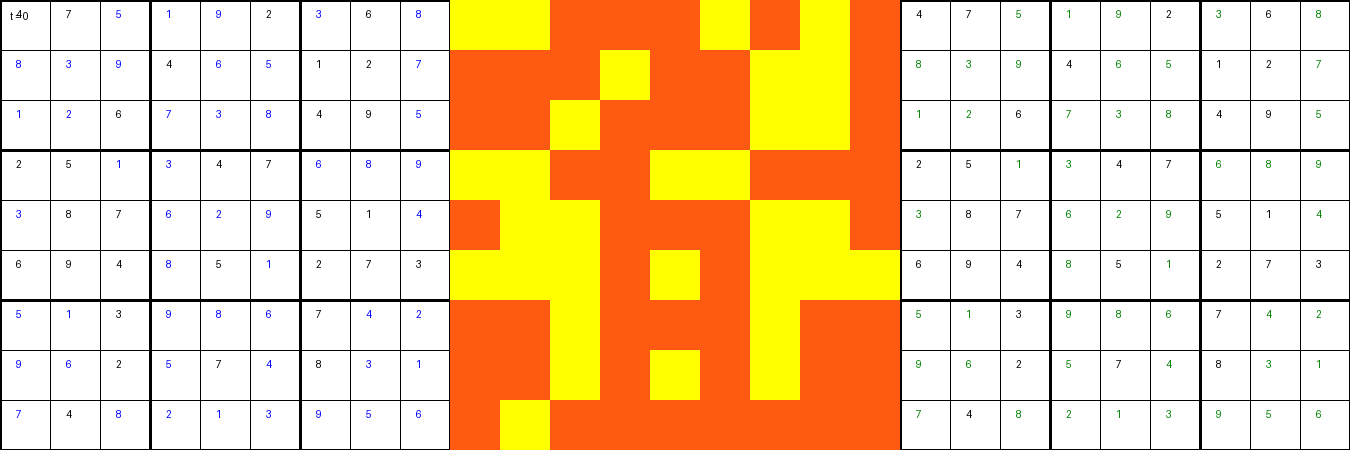

In [72]:
for t in range(4):
    print(f"⏱️ Step t = {3 - t}")
    panel = render_srm_rgb_panel(puzzle, steps[t], solutions[0], timestep=3 - t)
    display(panel)

In [106]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np

frames = []
for t in range(4):
    panel = render_srm_rgb_panel(puzzle, steps[t], solutions[0], timestep=3 - t)
    frames.append(panel)

In [107]:
gif_path = "sudoku_srm_visualization.gif"
frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=1200,
    loop=0
)
print(f"GIF saved at {gif_path}")

GIF saved at sudoku_srm_visualization.gif


In [108]:
import os

os.makedirs("/mnt/data", exist_ok=True)
gif_path = "/mnt/data/sudoku_srm_visualization.gif"
frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=1200,
    loop=0
)
print(f"GIF saved at {gif_path}")

GIF saved at /mnt/data/sudoku_srm_visualization.gif


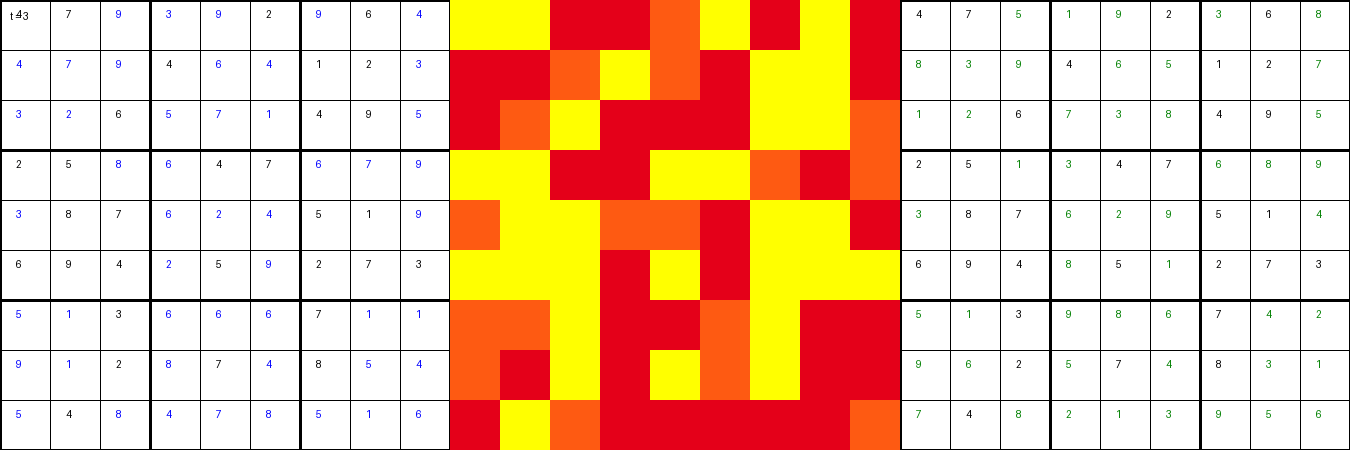

In [109]:
from IPython.display import Image as IPImage
display(IPImage(filename=gif_path))

In [120]:
from PIL import Image, ImageDraw, ImageFilter, ImageFont

def render_sudoku(grid, puzzle, glow_color=(0, 255, 128), digit_color=(255, 255, 255), glow_radius=2):
    img = Image.new('RGB', (GRID_SIZE, GRID_SIZE), color=(15, 15, 20))
    draw = ImageDraw.Draw(img)

    try:
        font = ImageFont.truetype("arial.ttf", FONT_SIZE)
    except:
        font = ImageFont.load_default()

    for i in range(10):
        width = 3 if i % 3 == 0 else 1
        line_color = (0, 255, 255)
        x = i * CELL_SIZE
        draw.line([(x, 0), (x, GRID_SIZE)], fill=line_color, width=width)
        draw.line([(0, x), (GRID_SIZE, x)], fill=line_color, width=width)

    for r in range(9):
        for c in range(9):
            val = grid[r][c]
            if val != 0:
                x = c * CELL_SIZE + CELL_SIZE // 3
                y = r * CELL_SIZE + CELL_SIZE // 6

                glow_base = glow_color if puzzle[r][c] == 0 else (0, 255, 255)

                glow_layer = Image.new('RGBA', (CELL_SIZE, CELL_SIZE), (0,0,0,0))
                glow_draw = ImageDraw.Draw(glow_layer)

                for dx in [-glow_radius, 0, glow_radius]:
                    for dy in [-glow_radius, 0, glow_radius]:
                        glow_draw.text((dx + CELL_SIZE//3, dy + CELL_SIZE//6), str(val), font=font, fill=glow_base+(100,))

                glow_layer = glow_layer.filter(ImageFilter.GaussianBlur(radius=2))
                img.paste(glow_layer, (c * CELL_SIZE, r * CELL_SIZE), glow_layer)

                draw.text((x, y), str(val), fill=digit_color, font=font)

    return img

🟠 Noisy input x_t (techie style):


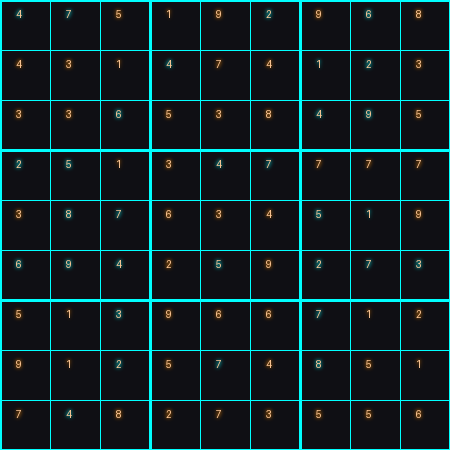

🟢 Single-step denoised x̂₀ (techie style):


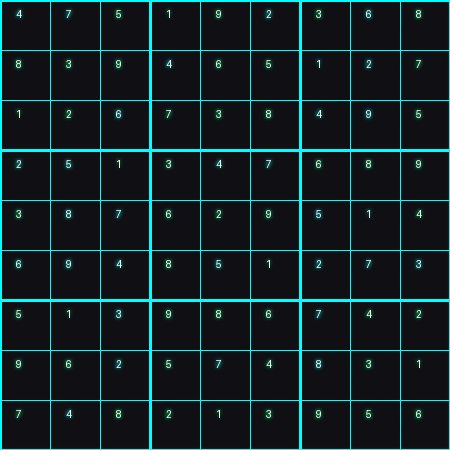

In [121]:
noisy_img = render_sudoku(noisy_input, puzzle, glow_color=(255, 140, 0), digit_color=(255, 200, 150))

denoised_img = render_sudoku(x_hat_0, puzzle, glow_color=(0, 255, 128), digit_color=(240, 255, 240))

print("🟠 Noisy input x_t (techie style):")
display(noisy_img)

print("🟢 Single-step denoised x̂₀ (techie style):")
display(denoised_img)

In [122]:
frames = []

frames.append (render_sudoku(noisy_input, puzzle, glow_color=(255, 140, 0), digit_color=(255, 200, 150)))

frames.append (render_sudoku(x_hat_0, puzzle, glow_color=(0, 255, 128), digit_color=(240, 255, 240)))

In [123]:
gif_path = "single_step_denoise.gif"
frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=1500,
    loop=0
)
print(f"GIF saved at {gif_path}")

GIF saved at single_step_denoise.gif


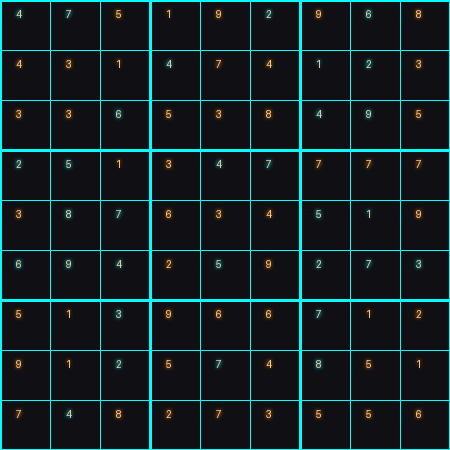

In [124]:
from IPython.display import Image as IPImage
display(IPImage(filename=gif_path))